we start by data exploration and visualization we know image classes of an image depend to their location / folder names in the following
we print the name of sub folders at each data groupe(train, val and test) after this we will exploit the cardinality of each data folder to
build an idea about the data size and relative folder sizes

In [1]:
from pathlib import Path
import os
directory_to_extract_to = ''
# we first define data paths
data_dir = Path(directory_to_extract_to)  #
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'
# Path to validation directory
val_dir = data_dir / 'val'
# Path to test directory
test_dir = data_dir / 'test'
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']


as one may notice the data is split into two classes namely "Pneumonia" and "Normal" next we will check how many image each
folder contain and then how many image each category contain.

In [2]:
import tensorflow as tf

train_filenames = tf.io.gfile.glob(str(train_dir) + '/*/*jpeg')
print('train data contain', len(train_filenames), 'dataframe')

val_filenames = tf.io.gfile.glob(str(val_dir) + '/*/*jpeg')
print('validation data contain', len(val_filenames), 'dataframe')

test_filenames = tf.io.gfile.glob(str(test_dir) + '/*/*jpeg')
print('test data contain', len(test_filenames), 'dataframe')

train_normal = tf.io.gfile.glob(str(train_dir) + '/NORMAL/*jpeg')
print('train data contain', len(train_normal), ' Normal dataframe')

train_pneumonia = tf.io.gfile.glob(str(train_dir) + '/PNEUMONIA/*jpeg')
print('train data contain', len(train_pneumonia), 'Pneumonia dataframe')

val_normal = tf.io.gfile.glob(str(val_dir) + '/NORMAL/*jpeg')
print('validation data contain', len(val_normal), ' Normal dataframe')

val_pneumonia = tf.io.gfile.glob(str(val_dir) + '/PNEUMONIA/*jpeg')
print('validation data contain', len(val_pneumonia), 'Pneumonia dataframe')

train data contain 5216 dataframe
validation data contain 16 dataframe
test data contain 624 dataframe
train data contain 1341  Normal dataframe
train data contain 3875 Pneumonia dataframe
validation data contain 8  Normal dataframe
validation data contain 8 Pneumonia dataframe


In [3]:
if 1:
    from sklearn.model_selection import train_test_split

    train_filenames.extend(val_filenames)
    train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2, random_state=42)
    print('training data length: ', len(train_filenames))
    print('validation data length: ', len(val_filenames))

training data length:  4185
validation data length:  1047


In [5]:
def label_data(data_list, weight_for_0, weight_for_1):
    labeled_data = []
    for name in data_list:
        labeled_data.append([name, weight_for_0]) if 'NORMAL' in name else labeled_data.append([name, weight_for_1])
    return labeled_data

In [6]:
import numpy as np

train_data = label_data(train_filenames, 0, 1)


In [25]:
count_train = len(train_data)
count_pneumonia = sum(np.array(train_data)[:, 1].astype(int))
count_normal = count_train - count_pneumonia
initial_bias = np.log(count_pneumonia/count_normal)
print('initial bias: ', initial_bias)
print('Pneummonia train data length: ', count_pneumonia)
print('Healthy train data length: ', count_normal)

initial bias:  1.0824291653800155
Pneummonia train data length:  3126
Healthy train data length:  1059


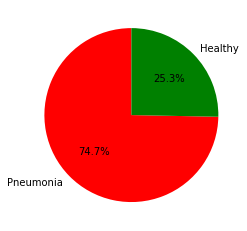

In [23]:
slices_hours = [count_pneumonia, count_normal]
activities = ['Pneumonia', 'Healthy']
colors = ['r', 'g']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

when we have exploited the data cardinalities one can also notice an imbalance between data classes(3875 Pneumonia dataframe vs
1341 Normal dataframe) this was also has affected the training data. training data classes imbalance is mentioned above

['train\\PNEUMONIA\\person1525_virus_2659.jpeg'
 'train\\PNEUMONIA\\person1129_bacteria_3070.jpeg'
 'train\\PNEUMONIA\\person1667_bacteria_4417.jpeg'
 'train\\PNEUMONIA\\person1300_virus_2240.jpeg'
 'train\\PNEUMONIA\\person71_bacteria_349.jpeg']
['train\\NORMAL\\NORMAL2-IM-1062-0001.jpeg'
 'train\\NORMAL\\NORMAL2-IM-0725-0001.jpeg'
 'train\\NORMAL\\IM-0363-0001.jpeg'
 'train\\NORMAL\\NORMAL2-IM-0868-0001.jpeg'
 'train\\NORMAL\\IM-0205-0001.jpeg']


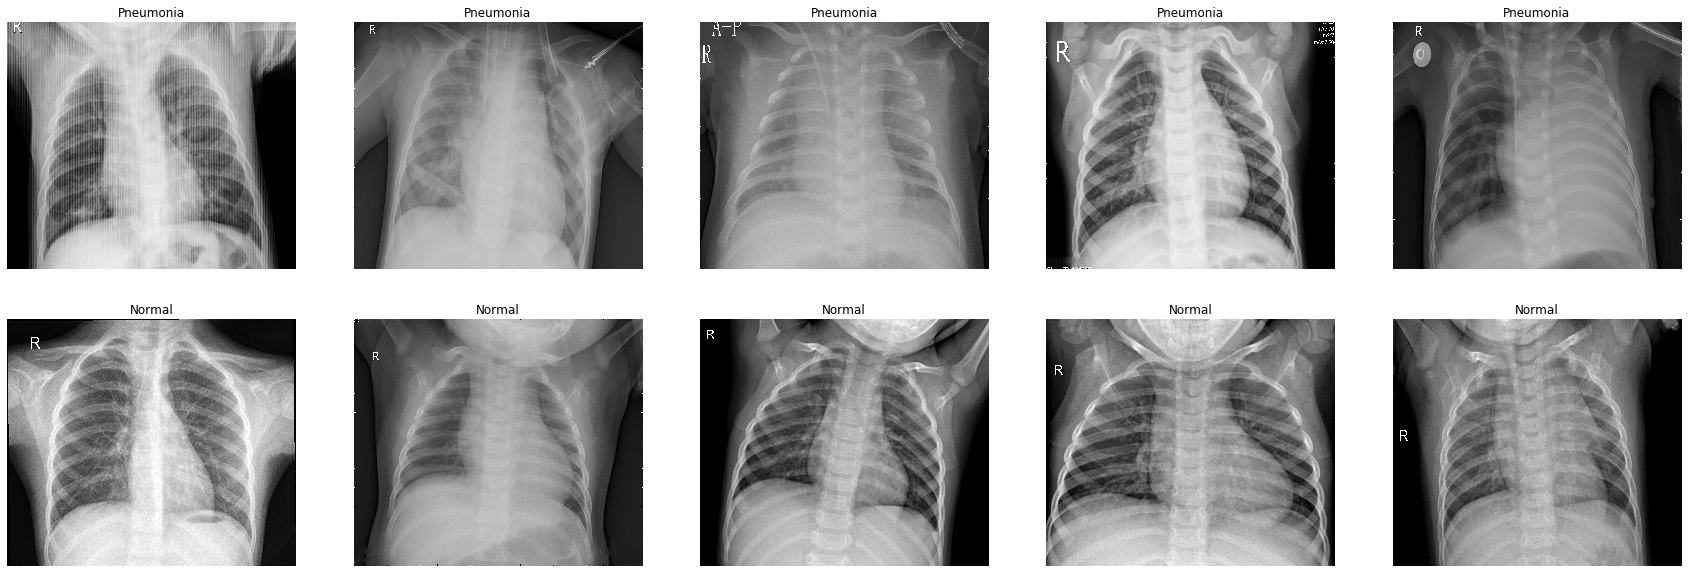

In [17]:
import matplotlib.pyplot as plt
from skimage.io import imread
# in this cell we visualize some helathy and Pneumonia samples

pneumonia_samples = (np.array(train_data)[:, 1].astype(int)==1)
pneumonia_samples = (np.array(train_data)[pneumonia_samples, 0])[:5]
print(pneumonia_samples)

normal_samples = (np.array(train_data)[:, 1].astype(int)==0)
normal_samples = (np.array(train_data)[normal_samples, 0])[:5]
print(normal_samples)

to_plot_smaples = np.concatenate((pneumonia_samples, normal_samples), axis=0)


# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(10):
    img = imread(to_plot_smaples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [18]:
weight_for_0 = (1/count_normal)*(count_train)/2.0
weight_for_1 = (1/count_pneumonia)*(count_train)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.98
Weight for class 1: 0.67


In [7]:
# affect new wights to as labels
train_data = label_data(train_filenames, weight_for_0, weight_for_1)
val_data = label_data(val_filenames, weight_for_0, weight_for_1)

In [8]:
image_size = (224, 224)
from PIL import Image

def buid_xy(data):
    x, y = [], []
    for name, label in data:
        im = Image.open(name)
        im = tf.image.convert_image_dtype(np.array(im), tf.float32)
        if len(im.shape) < 3:
            im = tf.expand_dims(im, axis=-1)
            im = tf.image.grayscale_to_rgb(im)
        im = tf.image.resize(im, image_size)
        label = tf.keras.utils.to_categorical(label, num_classes=2)
        x.append(np.array(im))
        y.append(np.array(label))
    return x, y

In [12]:
trainx, trainy = buid_xy(train_data)
print(np.array(trainx).shape)
valx, valy = buid_xy(val_data)
print(np.array(valy).shape)

(4185, 224, 224, 3)
(1047, 2)


In [13]:
# some clean up to save memory
try:
    del train_data
except:
    pass
try:
    del val_data
except:
    pass
try:
    del train_filenames
except:
    pass
try:
    del val_filenames
except:
    pass

In [14]:
print(np.array(trainx).shape)
print(np.array(trainy).shape)
print(np.array(valx).shape)
print(np.array(valy).shape)

(4185, 224, 224, 3)
(4185, 2)
(1047, 224, 224, 3)
(1047, 2)


In [ ]:
# we save the data in npy files to avoid the prerocessing for future running
upload_dir = './upload'
if not os.path.exists(upload_dir):  # Make sure that the folder exists
    os.makedirs(upload_dir)


np.save(os.path.join(upload_dir, 'training_label.npy'), np.array(trainy))
np.save(os.path.join(upload_dir, 'training.npy'), np.array(trainx))

np.save(os.path.join(upload_dir, 'validation.npy'), np.array(valx))
np.save(os.path.join(upload_dir, 'validation_label.npy'), np.array(valy))

In [10]:
# some cleaning up!
try:
    del trainx
except:
    pass
try:
    del valx
except:
    pass
try:
    del trainy
except:
    pass
try:
    del valy
except:
    pass

In [30]:
def build_model():
    """Model function for CNN."""
    image_size = [224,224]
    frozen_layers = [1, 2, 4, 5]
    vgg16_model = tf.keras.applications.VGG16(
        include_top=False, weights='imagenet', input_tensor=None,
        input_shape=(image_size[0], image_size[1], 3)
    )
    for i, layer in enumerate(vgg16_model.layers):
        if i in frozen_layers:
            # layer.require_grad = False
            layer.trainable = False
    model = tf.keras.Sequential()
    # Add the vgg convolutional base model
    model.add(vgg16_model)
    # Add new layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    return model

In [20]:
model =  build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 14,504,706
Non-trainable params: 260,160
_________________________________________________________________


In [21]:
checkpoint_path = "training_1/cp4.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=METRICS
)

In [23]:
def load_training_data(base_dir):
    X_train = np.load(os.path.join(base_dir, 'training.npy'))
    y_train = np.load(os.path.join(base_dir, 'training_label.npy'))
    return X_train, y_train


def load_validation_data(base_dir):
    X_val = np.load(os.path.join(base_dir, 'validation.npy'))
    y_val = np.load(os.path.join(base_dir, 'validation_label.npy'))
    return X_val, y_val

In [25]:
upload_dir = './upload'
trainx, trainy= load_training_data(upload_dir)
valx, valy = load_validation_data(upload_dir)

In [26]:
TRAIN_IMG_COUNT = len(trainx)
VAL_IMG_COUNT = len(valx)
batch_size=16
epochs=20
history = model.fit(x=trainx,
                    y=trainy, 
                    steps_per_epoch=TRAIN_IMG_COUNT // batch_size,
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(valx, valy),
                    validation_steps=VAL_IMG_COUNT,
                    class_weight=class_weight,
                    callbacks=[cp_callback])

Epoch 1/20
261/261 [==============================] - 1080s 4s/step - loss: 0.2405 - accuracy: 0.8809 - precision: 0.8809 - recall: 0.8809 - val_loss: 0.0772 - val_accuracy: 0.9723 - val_precision: 0.9723 - val_recall: 0.9723

Epoch 00001: saving model to training_1\cp4.ckpt
Epoch 2/20
261/261 [==============================] - 1017s 4s/step - loss: 0.0665 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768

Epoch 00002: saving model to training_1\cp4.ckpt
Epoch 3/20
261/261 [==============================] - 994s 4s/step - loss: 0.0477 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779

Epoch 00003: saving model to training_1\cp4.ckpt
Epoch 4/20
261/261 [==============================] - 1002s 4s/step - loss: 0.0519 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791

Epoch 00004: saving model to training_1\cp4.ckpt
Epoch 5/20
261/261 [==============================] - 999s 4s/step - loss: 0.0251 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894

Epoch 00005: saving

In [27]:
model.save('model2_softmax')

INFO:tensorflow:Assets written to: model2_softmax\assets


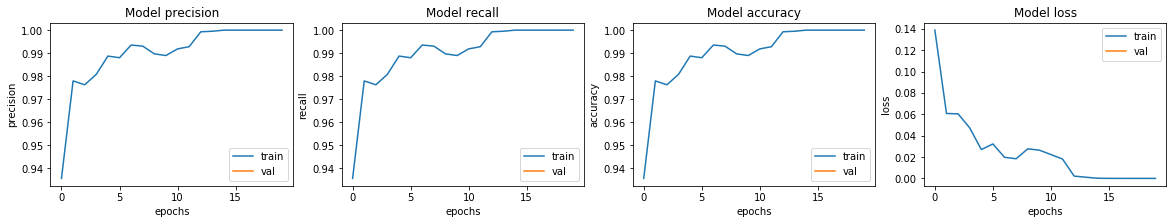

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
# prepare test data
test_data = label_data(test_filenames, weight_for_0, weight_for_1)
testx, testy = buid_xy(test_data)

In [31]:
preds = model.predict(np.array(testx), batch_size=16)

In [33]:
preds = np.argmax(preds, axis=-1)#['predictions']
# Original labels
orig_test_labels = np.argmax(testy, axis=-1)
print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [41]:
loss, acc, prec, rec = model.evaluate(np.array(testx), np.array(testy),verbose=2)

20/20 - 52s - loss: 4.7537 - accuracy: 0.7564 - precision: 0.7564 - recall: 0.7564


I got this function form here https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

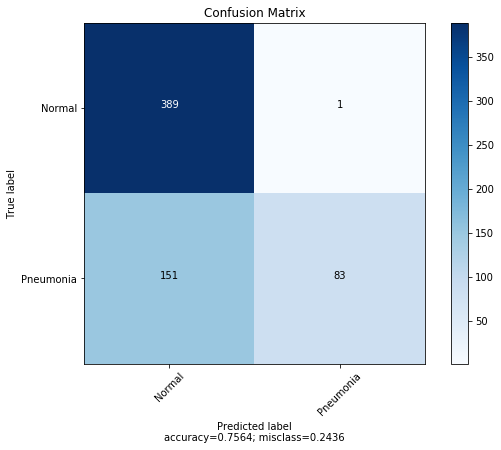

In [35]:
cm = tf.math.confusion_matrix(orig_test_labels, preds)
plot_confusion_matrix(cm=np.array(cm),
                      normalize=False,
                      target_names=['Normal', 'Pneumonia'],
                      title="Confusion Matrix")